# Program Description: Machine Learning Modeling (MLP - Classification)

## Overview:
- This module is responsible for building a **classification model** using a **multi-layer perceptron (MLP)** neural network. 
- The model is trained using the dataset output from **Module 9**, which contains **normalized data**.
- After training, the best model is saved, and predictions are made on the test set.

## Key Steps:

1. **Dataset Input:**
   - The feature and label datasets for training and validation are read from the output of **Module 9**.
   - These datasets are preprocessed and normalized.

2. **Model Building:**
   - A multi-layer perceptron (MLP) neural network model is constructed and trained on the data.
   - The best-performing model during training is saved for future use.

3. **Prediction and Evaluation:**
   - The trained model is used to make predictions on the validation or test dataset.
   - Model performance is evaluated using relevant classification metrics (accuracy, F1 score, etc.).

4. **Output:**
   - The trained model is saved in the `datasets-ml` folder within the current working directory.
   - Each run saves the model with a unique timestamp in the format: `MLPmodel--{current_time}`.

## Output Files:
- **Trained Model:**
  - Stored in the `datasets-ml` folder under a file name containing the timestamp.
  - Example: `MLPmodel--{current_time}.h5`.

- **Predictions:**
  - The model's predictions are saved in a separate file (e.g., `predictions.csv`) for later analysis.

## Logging and Monitoring:
- Logs are generated to track the training progress, dataset sizes, and model performance metrics.


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import os
import sys
import pkg_resources
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from datetime import datetime
from tensorflow.keras import regularizers
import keras.callbacks
from IPython.display import Image, display
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterSampler, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss


2025-01-21 10:03:01.484884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


##  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','seaborn','sklearn']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
seaborn: 0.13.2
sklearn: 1.3.2
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings (Input File, Output File)

## Input File Path:
- `dir_data`: Specifies the directory where the preprocessed dataset is located.
- The dataset includes **training**, **validation**, and **test** sets generated in **Module 9**.
- Example: `'0926-datasets/datasets(JmolNN)-pre-xmu-cn'`.

## Output File Path:
- `output_path`: The directory where the trained model will be saved.
- The model and logs will be stored under the `datasets-ml` folder in the current working path.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'`.

## Model Output File Name:
- `dir_output`: The output save file name, which includes a timestamp (`current_time`), ensuring a unique file name for each run.
- Example: `'MLPmodel-{current_time}'` where `{current_time}` is the timestamp formatted as `YYYYMMDD_HHMM`.

## Logging Configuration:
- A log file (`training_log.txt`) will be generated to track the training progress, dataset sizes, and model details.
- The log is stored in the output directory, providing real-time updates for monitoring.

## Data Loading:
- `file_train_feature`, `file_train_label`: Specifies the file paths for training features and labels.
- `file_valid_feature`, `file_valid_label`: Specifies the file paths for validation features and labels.
- `file_test_feature`, `file_test_label`: Specifies the file paths for test features and labels.


In [3]:
# Set input file path
dir_data = '0926-datasets/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
current_time = datetime.now().strftime("%Y%m%d_%H%M")
# Output save file name and add timestamp
dir_output=os.path.join(output_path,f'MLPmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
# Load training, validation, and test datasets
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_valid:", np.unique(y_valid))
print("Unique labels in y_test:", np.unique(y_test))
logging.info(f"Unique labels in y_train: {np.unique(y_train)}")
logging.info(f"Unique labels in y_valid: {np.unique(y_valid)}")
logging.info(f"Unique labels in y_test: {np.unique(y_test)}")

File '0926-datasets/datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3465, 1000), y_train: (3465,)
Validation set size: X_valid: (990, 1000), y_valid: (990,)
Test set size: X_test: (495, 1000), y_test: (495,)
Unique labels in y_train: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_valid: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_test: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


Training set size: X_train: (3465, 1000), y_train: (3465,)
Validation set size: X_valid: (990, 1000), y_valid: (990,)
Test set size: X_test: (495, 1000), y_test: (495,)
Unique labels in y_train: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_valid: [ 3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
Unique labels in y_test: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


# Build a MLP classification model and save the best model results

In [4]:
all_labels = np.concatenate((y_train, y_valid, y_test))
num_classes = len(np.unique(all_labels))
min_label = np.min(all_labels)
y_train = to_categorical(y_train - min_label, num_classes=num_classes)
y_valid = to_categorical(y_valid - min_label, num_classes=num_classes)
y_test = to_categorical(y_test - min_label, num_classes=num_classes)
#model.add(Dense(num_classes, activation='softmax')) 
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','mae'])
model_file = os.path.join(dir_output, 'best_model.h5')
checkpoint = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"Accuracy: {logs['accuracy']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, "
                       f"Val_Accuracy: {logs['val_accuracy']:.4f}")
        logging.info(log_message)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint, CustomCallback()])


2025-01-21 10:03:04.813779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
107/109 [============================>.] - ETA: 0s - loss: 4.0390 - accuracy: 0.3989 - mae: 0.1239
Epoch 1: val_accuracy improved from -inf to 0.42222, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 1, Loss: 4.0242, Accuracy: 0.3994, Val_Loss: 2.8290, Val_Accuracy: 0.4222


109/109 [==============================] - 2s 10ms/step - loss: 4.0242 - accuracy: 0.3994 - mae: 0.1237 - val_loss: 2.8290 - val_accuracy: 0.4222 - val_mae: 0.1166
Epoch 2/100
103/109 [===========================>..] - ETA: 0s - loss: 2.3844 - accuracy: 0.4463 - mae: 0.1185
Epoch 2: val_accuracy improved from 0.42222 to 0.42626, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 2, Loss: 2.3624, Accuracy: 0.4499, Val_Loss: 2.0467, Val_Accuracy: 0.4263


109/109 [==============================] - 1s 7ms/step - loss: 2.3624 - accuracy: 0.4499 - mae: 0.1182 - val_loss: 2.0467 - val_accuracy: 0.4263 - val_mae: 0.1158
Epoch 3/100
 99/109 [==========================>...] - ETA: 0s - loss: 1.8423 - accuracy: 0.4558 - mae: 0.1171
Epoch 3: val_accuracy improved from 0.42626 to 0.46465, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 3, Loss: 1.8285, Accuracy: 0.4609, Val_Loss: 1.6686, Val_Accuracy: 0.4646


109/109 [==============================] - 1s 7ms/step - loss: 1.8285 - accuracy: 0.4609 - mae: 0.1171 - val_loss: 1.6686 - val_accuracy: 0.4646 - val_mae: 0.1169
Epoch 4/100
106/109 [============================>.] - ETA: 0s - loss: 1.5754 - accuracy: 0.4711 - mae: 0.1154
Epoch 4: val_accuracy did not improve from 0.46465


Epoch 4, Loss: 1.5761, Accuracy: 0.4710, Val_Loss: 1.5239, Val_Accuracy: 0.4535


109/109 [==============================] - 1s 8ms/step - loss: 1.5761 - accuracy: 0.4710 - mae: 0.1154 - val_loss: 1.5239 - val_accuracy: 0.4535 - val_mae: 0.1156
Epoch 5/100
109/109 [==============================] - ETA: 0s - loss: 1.4805 - accuracy: 0.4531 - mae: 0.1162
Epoch 5: val_accuracy did not improve from 0.46465


Epoch 5, Loss: 1.4805, Accuracy: 0.4531, Val_Loss: 1.4267, Val_Accuracy: 0.4626


109/109 [==============================] - 1s 7ms/step - loss: 1.4805 - accuracy: 0.4531 - mae: 0.1162 - val_loss: 1.4267 - val_accuracy: 0.4626 - val_mae: 0.1149
Epoch 6/100
107/109 [============================>.] - ETA: 0s - loss: 1.4078 - accuracy: 0.4740 - mae: 0.1150
Epoch 6: val_accuracy improved from 0.46465 to 0.48990, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 6, Loss: 1.4071, Accuracy: 0.4745, Val_Loss: 1.3676, Val_Accuracy: 0.4899


109/109 [==============================] - 1s 7ms/step - loss: 1.4071 - accuracy: 0.4745 - mae: 0.1150 - val_loss: 1.3676 - val_accuracy: 0.4899 - val_mae: 0.1130
Epoch 7/100
109/109 [==============================] - ETA: 0s - loss: 1.3536 - accuracy: 0.4805 - mae: 0.1131
Epoch 7: val_accuracy improved from 0.48990 to 0.50303, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 7, Loss: 1.3536, Accuracy: 0.4805, Val_Loss: 1.3035, Val_Accuracy: 0.5030


109/109 [==============================] - 1s 8ms/step - loss: 1.3536 - accuracy: 0.4805 - mae: 0.1131 - val_loss: 1.3035 - val_accuracy: 0.5030 - val_mae: 0.1129
Epoch 8/100
106/109 [============================>.] - ETA: 0s - loss: 1.3529 - accuracy: 0.4738 - mae: 0.1136
Epoch 8: val_accuracy did not improve from 0.50303


Epoch 8, Loss: 1.3516, Accuracy: 0.4765, Val_Loss: 1.3073, Val_Accuracy: 0.4859


109/109 [==============================] - 1s 7ms/step - loss: 1.3516 - accuracy: 0.4765 - mae: 0.1134 - val_loss: 1.3073 - val_accuracy: 0.4859 - val_mae: 0.1119
Epoch 9/100
109/109 [==============================] - ETA: 0s - loss: 1.3118 - accuracy: 0.4895 - mae: 0.1116
Epoch 9: val_accuracy improved from 0.50303 to 0.52222, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 9, Loss: 1.3118, Accuracy: 0.4895, Val_Loss: 1.2959, Val_Accuracy: 0.5222


109/109 [==============================] - 1s 8ms/step - loss: 1.3118 - accuracy: 0.4895 - mae: 0.1116 - val_loss: 1.2959 - val_accuracy: 0.5222 - val_mae: 0.1125
Epoch 10/100
109/109 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.5100 - mae: 0.1083
Epoch 10: val_accuracy did not improve from 0.52222


Epoch 10, Loss: 1.2607, Accuracy: 0.5100, Val_Loss: 1.3396, Val_Accuracy: 0.4838


109/109 [==============================] - 1s 9ms/step - loss: 1.2607 - accuracy: 0.5100 - mae: 0.1083 - val_loss: 1.3396 - val_accuracy: 0.4838 - val_mae: 0.1158
Epoch 11/100
107/109 [============================>.] - ETA: 0s - loss: 1.2558 - accuracy: 0.5143 - mae: 0.1073
Epoch 11: val_accuracy improved from 0.52222 to 0.54141, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 11, Loss: 1.2572, Accuracy: 0.5146, Val_Loss: 1.2706, Val_Accuracy: 0.5414


109/109 [==============================] - 1s 12ms/step - loss: 1.2572 - accuracy: 0.5146 - mae: 0.1074 - val_loss: 1.2706 - val_accuracy: 0.5414 - val_mae: 0.1069
Epoch 12/100
104/109 [===========================>..] - ETA: 0s - loss: 1.2498 - accuracy: 0.5123 - mae: 0.1068
Epoch 12: val_accuracy did not improve from 0.54141


Epoch 12, Loss: 1.2506, Accuracy: 0.5134, Val_Loss: 1.3343, Val_Accuracy: 0.4778


109/109 [==============================] - 1s 11ms/step - loss: 1.2506 - accuracy: 0.5134 - mae: 0.1069 - val_loss: 1.3343 - val_accuracy: 0.4778 - val_mae: 0.1047
Epoch 13/100
107/109 [============================>.] - ETA: 0s - loss: 1.1957 - accuracy: 0.5356 - mae: 0.1035
Epoch 13: val_accuracy did not improve from 0.54141


Epoch 13, Loss: 1.1946, Accuracy: 0.5359, Val_Loss: 1.3243, Val_Accuracy: 0.5051


109/109 [==============================] - 1s 8ms/step - loss: 1.1946 - accuracy: 0.5359 - mae: 0.1035 - val_loss: 1.3243 - val_accuracy: 0.5051 - val_mae: 0.1111
Epoch 14/100
106/109 [============================>.] - ETA: 0s - loss: 1.2119 - accuracy: 0.5315 - mae: 0.1034
Epoch 14: val_accuracy did not improve from 0.54141


Epoch 14, Loss: 1.2071, Accuracy: 0.5351, Val_Loss: 1.1888, Val_Accuracy: 0.5222


109/109 [==============================] - 1s 12ms/step - loss: 1.2071 - accuracy: 0.5351 - mae: 0.1032 - val_loss: 1.1888 - val_accuracy: 0.5222 - val_mae: 0.1012
Epoch 15/100
107/109 [============================>.] - ETA: 0s - loss: 1.1260 - accuracy: 0.5724 - mae: 0.0966
Epoch 15: val_accuracy did not improve from 0.54141


Epoch 15, Loss: 1.1274, Accuracy: 0.5717, Val_Loss: 1.4730, Val_Accuracy: 0.4172


109/109 [==============================] - 1s 11ms/step - loss: 1.1274 - accuracy: 0.5717 - mae: 0.0966 - val_loss: 1.4730 - val_accuracy: 0.4172 - val_mae: 0.1162
Epoch 16/100
101/109 [==========================>...] - ETA: 0s - loss: 1.1810 - accuracy: 0.5523 - mae: 0.1010
Epoch 16: val_accuracy improved from 0.54141 to 0.58990, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 16, Loss: 1.1769, Accuracy: 0.5532, Val_Loss: 1.1080, Val_Accuracy: 0.5899


109/109 [==============================] - 1s 10ms/step - loss: 1.1769 - accuracy: 0.5532 - mae: 0.1008 - val_loss: 1.1080 - val_accuracy: 0.5899 - val_mae: 0.0956
Epoch 17/100
107/109 [============================>.] - ETA: 0s - loss: 1.1291 - accuracy: 0.5680 - mae: 0.0965
Epoch 17: val_accuracy did not improve from 0.58990


Epoch 17, Loss: 1.1268, Accuracy: 0.5694, Val_Loss: 1.0941, Val_Accuracy: 0.5758


109/109 [==============================] - 1s 10ms/step - loss: 1.1268 - accuracy: 0.5694 - mae: 0.0965 - val_loss: 1.0941 - val_accuracy: 0.5758 - val_mae: 0.0929
Epoch 18/100
104/109 [===========================>..] - ETA: 0s - loss: 1.0860 - accuracy: 0.5965 - mae: 0.0921
Epoch 18: val_accuracy improved from 0.58990 to 0.61515, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 18, Loss: 1.0919, Accuracy: 0.5922, Val_Loss: 1.0483, Val_Accuracy: 0.6152


109/109 [==============================] - 1s 12ms/step - loss: 1.0919 - accuracy: 0.5922 - mae: 0.0924 - val_loss: 1.0483 - val_accuracy: 0.6152 - val_mae: 0.0932
Epoch 19/100
104/109 [===========================>..] - ETA: 0s - loss: 1.0709 - accuracy: 0.5947 - mae: 0.0934
Epoch 19: val_accuracy did not improve from 0.61515


Epoch 19, Loss: 1.0714, Accuracy: 0.5945, Val_Loss: 1.1233, Val_Accuracy: 0.6000


109/109 [==============================] - 1s 10ms/step - loss: 1.0714 - accuracy: 0.5945 - mae: 0.0934 - val_loss: 1.1233 - val_accuracy: 0.6000 - val_mae: 0.0931
Epoch 20/100
109/109 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.5838 - mae: 0.0942
Epoch 20: val_accuracy did not improve from 0.61515


Epoch 20, Loss: 1.0924, Accuracy: 0.5838, Val_Loss: 1.0960, Val_Accuracy: 0.6051


109/109 [==============================] - 1s 11ms/step - loss: 1.0924 - accuracy: 0.5838 - mae: 0.0942 - val_loss: 1.0960 - val_accuracy: 0.6051 - val_mae: 0.0934
Epoch 21/100
105/109 [===========================>..] - ETA: 0s - loss: 1.0619 - accuracy: 0.5997 - mae: 0.0923
Epoch 21: val_accuracy improved from 0.61515 to 0.62929, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 21, Loss: 1.0610, Accuracy: 0.6000, Val_Loss: 1.0116, Val_Accuracy: 0.6293


109/109 [==============================] - 1s 12ms/step - loss: 1.0610 - accuracy: 0.6000 - mae: 0.0922 - val_loss: 1.0116 - val_accuracy: 0.6293 - val_mae: 0.0904
Epoch 22/100
101/109 [==========================>...] - ETA: 0s - loss: 1.0736 - accuracy: 0.5891 - mae: 0.0938
Epoch 22: val_accuracy did not improve from 0.62929


Epoch 22, Loss: 1.0676, Accuracy: 0.5913, Val_Loss: 1.0219, Val_Accuracy: 0.6253


109/109 [==============================] - 1s 8ms/step - loss: 1.0676 - accuracy: 0.5913 - mae: 0.0935 - val_loss: 1.0219 - val_accuracy: 0.6253 - val_mae: 0.0902
Epoch 23/100
104/109 [===========================>..] - ETA: 0s - loss: 1.0770 - accuracy: 0.5968 - mae: 0.0940
Epoch 23: val_accuracy did not improve from 0.62929


Epoch 23, Loss: 1.0717, Accuracy: 0.5991, Val_Loss: 1.0398, Val_Accuracy: 0.6162


109/109 [==============================] - 1s 11ms/step - loss: 1.0717 - accuracy: 0.5991 - mae: 0.0937 - val_loss: 1.0398 - val_accuracy: 0.6162 - val_mae: 0.0935
Epoch 24/100
106/109 [============================>.] - ETA: 0s - loss: 1.0031 - accuracy: 0.6200 - mae: 0.0885
Epoch 24: val_accuracy did not improve from 0.62929


Epoch 24, Loss: 0.9994, Accuracy: 0.6208, Val_Loss: 1.0414, Val_Accuracy: 0.6061


109/109 [==============================] - 1s 11ms/step - loss: 0.9994 - accuracy: 0.6208 - mae: 0.0883 - val_loss: 1.0414 - val_accuracy: 0.6061 - val_mae: 0.0915
Epoch 25/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9908 - accuracy: 0.6235 - mae: 0.0864
Epoch 25: val_accuracy improved from 0.62929 to 0.64040, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 25, Loss: 0.9927, Accuracy: 0.6208, Val_Loss: 0.9774, Val_Accuracy: 0.6404


109/109 [==============================] - 1s 11ms/step - loss: 0.9927 - accuracy: 0.6208 - mae: 0.0864 - val_loss: 0.9774 - val_accuracy: 0.6404 - val_mae: 0.0882
Epoch 26/100
104/109 [===========================>..] - ETA: 0s - loss: 1.0177 - accuracy: 0.6061 - mae: 0.0885
Epoch 26: val_accuracy improved from 0.64040 to 0.64646, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 26, Loss: 1.0144, Accuracy: 0.6078, Val_Loss: 0.9615, Val_Accuracy: 0.6465


109/109 [==============================] - 1s 12ms/step - loss: 1.0144 - accuracy: 0.6078 - mae: 0.0884 - val_loss: 0.9615 - val_accuracy: 0.6465 - val_mae: 0.0865
Epoch 27/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9972 - accuracy: 0.6143 - mae: 0.0881
Epoch 27: val_accuracy did not improve from 0.64646


Epoch 27, Loss: 0.9984, Accuracy: 0.6127, Val_Loss: 0.9810, Val_Accuracy: 0.6242


109/109 [==============================] - 1s 11ms/step - loss: 0.9984 - accuracy: 0.6127 - mae: 0.0881 - val_loss: 0.9810 - val_accuracy: 0.6242 - val_mae: 0.0833
Epoch 28/100
107/109 [============================>.] - ETA: 0s - loss: 0.9752 - accuracy: 0.6294 - mae: 0.0854
Epoch 28: val_accuracy did not improve from 0.64646


Epoch 28, Loss: 0.9738, Accuracy: 0.6317, Val_Loss: 0.9871, Val_Accuracy: 0.6212


109/109 [==============================] - 1s 8ms/step - loss: 0.9738 - accuracy: 0.6317 - mae: 0.0853 - val_loss: 0.9871 - val_accuracy: 0.6212 - val_mae: 0.0896
Epoch 29/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9637 - accuracy: 0.6280 - mae: 0.0850
Epoch 29: val_accuracy did not improve from 0.64646


Epoch 29, Loss: 0.9599, Accuracy: 0.6291, Val_Loss: 0.9897, Val_Accuracy: 0.6020


109/109 [==============================] - 1s 11ms/step - loss: 0.9599 - accuracy: 0.6291 - mae: 0.0849 - val_loss: 0.9897 - val_accuracy: 0.6020 - val_mae: 0.0879
Epoch 30/100
107/109 [============================>.] - ETA: 0s - loss: 0.9547 - accuracy: 0.6332 - mae: 0.0845
Epoch 30: val_accuracy did not improve from 0.64646


Epoch 30, Loss: 0.9599, Accuracy: 0.6317, Val_Loss: 1.0877, Val_Accuracy: 0.5616


109/109 [==============================] - 1s 11ms/step - loss: 0.9599 - accuracy: 0.6317 - mae: 0.0846 - val_loss: 1.0877 - val_accuracy: 0.5616 - val_mae: 0.0903
Epoch 31/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9556 - accuracy: 0.6337 - mae: 0.0848
Epoch 31: val_accuracy improved from 0.64646 to 0.65051, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 31, Loss: 0.9533, Accuracy: 0.6341, Val_Loss: 0.9426, Val_Accuracy: 0.6505


109/109 [==============================] - 1s 10ms/step - loss: 0.9533 - accuracy: 0.6341 - mae: 0.0848 - val_loss: 0.9426 - val_accuracy: 0.6505 - val_mae: 0.0845
Epoch 32/100
107/109 [============================>.] - ETA: 0s - loss: 0.9939 - accuracy: 0.6084 - mae: 0.0878
Epoch 32: val_accuracy did not improve from 0.65051


Epoch 32, Loss: 0.9930, Accuracy: 0.6087, Val_Loss: 0.9887, Val_Accuracy: 0.6273


109/109 [==============================] - 1s 10ms/step - loss: 0.9930 - accuracy: 0.6087 - mae: 0.0878 - val_loss: 0.9887 - val_accuracy: 0.6273 - val_mae: 0.0893
Epoch 33/100
109/109 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 0.6335 - mae: 0.0843
Epoch 33: val_accuracy did not improve from 0.65051


Epoch 33, Loss: 0.9402, Accuracy: 0.6335, Val_Loss: 0.9961, Val_Accuracy: 0.6242


109/109 [==============================] - 1s 11ms/step - loss: 0.9402 - accuracy: 0.6335 - mae: 0.0843 - val_loss: 0.9961 - val_accuracy: 0.6242 - val_mae: 0.0827
Epoch 34/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9407 - accuracy: 0.6400 - mae: 0.0835
Epoch 34: val_accuracy did not improve from 0.65051


Epoch 34, Loss: 0.9435, Accuracy: 0.6375, Val_Loss: 0.9431, Val_Accuracy: 0.6384


109/109 [==============================] - 1s 10ms/step - loss: 0.9435 - accuracy: 0.6375 - mae: 0.0837 - val_loss: 0.9431 - val_accuracy: 0.6384 - val_mae: 0.0842
Epoch 35/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9646 - accuracy: 0.6185 - mae: 0.0865
Epoch 35: val_accuracy improved from 0.65051 to 0.65657, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 35, Loss: 0.9656, Accuracy: 0.6176, Val_Loss: 0.9093, Val_Accuracy: 0.6566


109/109 [==============================] - 1s 11ms/step - loss: 0.9656 - accuracy: 0.6176 - mae: 0.0866 - val_loss: 0.9093 - val_accuracy: 0.6566 - val_mae: 0.0828
Epoch 36/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9377 - accuracy: 0.6429 - mae: 0.0830
Epoch 36: val_accuracy did not improve from 0.65657


Epoch 36, Loss: 0.9393, Accuracy: 0.6427, Val_Loss: 0.9190, Val_Accuracy: 0.6535


109/109 [==============================] - 1s 11ms/step - loss: 0.9393 - accuracy: 0.6427 - mae: 0.0832 - val_loss: 0.9190 - val_accuracy: 0.6535 - val_mae: 0.0846
Epoch 37/100
106/109 [============================>.] - ETA: 0s - loss: 0.9484 - accuracy: 0.6285 - mae: 0.0856
Epoch 37: val_accuracy did not improve from 0.65657


Epoch 37, Loss: 0.9468, Accuracy: 0.6300, Val_Loss: 0.9452, Val_Accuracy: 0.6313


109/109 [==============================] - 1s 10ms/step - loss: 0.9468 - accuracy: 0.6300 - mae: 0.0855 - val_loss: 0.9452 - val_accuracy: 0.6313 - val_mae: 0.0875
Epoch 38/100
107/109 [============================>.] - ETA: 0s - loss: 0.9602 - accuracy: 0.6224 - mae: 0.0848
Epoch 38: val_accuracy improved from 0.65657 to 0.66566, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 38, Loss: 0.9597, Accuracy: 0.6228, Val_Loss: 0.9186, Val_Accuracy: 0.6657


109/109 [==============================] - 1s 12ms/step - loss: 0.9597 - accuracy: 0.6228 - mae: 0.0848 - val_loss: 0.9186 - val_accuracy: 0.6657 - val_mae: 0.0841
Epoch 39/100
106/109 [============================>.] - ETA: 0s - loss: 0.9296 - accuracy: 0.6383 - mae: 0.0844
Epoch 39: val_accuracy did not improve from 0.66566


Epoch 39, Loss: 0.9272, Accuracy: 0.6390, Val_Loss: 0.9151, Val_Accuracy: 0.6535


109/109 [==============================] - 1s 11ms/step - loss: 0.9272 - accuracy: 0.6390 - mae: 0.0844 - val_loss: 0.9151 - val_accuracy: 0.6535 - val_mae: 0.0828
Epoch 40/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9228 - accuracy: 0.6445 - mae: 0.0818
Epoch 40: val_accuracy did not improve from 0.66566


Epoch 40, Loss: 0.9222, Accuracy: 0.6459, Val_Loss: 0.9585, Val_Accuracy: 0.6232


109/109 [==============================] - 1s 10ms/step - loss: 0.9222 - accuracy: 0.6459 - mae: 0.0817 - val_loss: 0.9585 - val_accuracy: 0.6232 - val_mae: 0.0841
Epoch 41/100
108/109 [============================>.] - ETA: 0s - loss: 0.9385 - accuracy: 0.6337 - mae: 0.0837
Epoch 41: val_accuracy did not improve from 0.66566


Epoch 41, Loss: 0.9384, Accuracy: 0.6335, Val_Loss: 1.0329, Val_Accuracy: 0.5929


109/109 [==============================] - 1s 11ms/step - loss: 0.9384 - accuracy: 0.6335 - mae: 0.0838 - val_loss: 1.0329 - val_accuracy: 0.5929 - val_mae: 0.0861
Epoch 42/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9260 - accuracy: 0.6478 - mae: 0.0827
Epoch 42: val_accuracy did not improve from 0.66566


Epoch 42, Loss: 0.9343, Accuracy: 0.6442, Val_Loss: 0.9382, Val_Accuracy: 0.6374


109/109 [==============================] - 1s 11ms/step - loss: 0.9343 - accuracy: 0.6442 - mae: 0.0830 - val_loss: 0.9382 - val_accuracy: 0.6374 - val_mae: 0.0848
Epoch 43/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9747 - accuracy: 0.6229 - mae: 0.0881
Epoch 43: val_accuracy did not improve from 0.66566


Epoch 43, Loss: 0.9724, Accuracy: 0.6242, Val_Loss: 0.9457, Val_Accuracy: 0.6283


109/109 [==============================] - 1s 10ms/step - loss: 0.9724 - accuracy: 0.6242 - mae: 0.0878 - val_loss: 0.9457 - val_accuracy: 0.6283 - val_mae: 0.0842
Epoch 44/100
107/109 [============================>.] - ETA: 0s - loss: 0.9318 - accuracy: 0.6411 - mae: 0.0841
Epoch 44: val_accuracy did not improve from 0.66566


Epoch 44, Loss: 0.9301, Accuracy: 0.6418, Val_Loss: 0.9326, Val_Accuracy: 0.6303


109/109 [==============================] - 1s 11ms/step - loss: 0.9301 - accuracy: 0.6418 - mae: 0.0840 - val_loss: 0.9326 - val_accuracy: 0.6303 - val_mae: 0.0832
Epoch 45/100
107/109 [============================>.] - ETA: 0s - loss: 0.9205 - accuracy: 0.6405 - mae: 0.0833
Epoch 45: val_accuracy did not improve from 0.66566


Epoch 45, Loss: 0.9211, Accuracy: 0.6398, Val_Loss: 0.8920, Val_Accuracy: 0.6414


109/109 [==============================] - 1s 11ms/step - loss: 0.9211 - accuracy: 0.6398 - mae: 0.0834 - val_loss: 0.8920 - val_accuracy: 0.6414 - val_mae: 0.0814
Epoch 46/100
104/109 [===========================>..] - ETA: 0s - loss: 0.9130 - accuracy: 0.6436 - mae: 0.0823
Epoch 46: val_accuracy did not improve from 0.66566


Epoch 46, Loss: 0.9098, Accuracy: 0.6459, Val_Loss: 0.9165, Val_Accuracy: 0.6303


109/109 [==============================] - 1s 8ms/step - loss: 0.9098 - accuracy: 0.6459 - mae: 0.0821 - val_loss: 0.9165 - val_accuracy: 0.6303 - val_mae: 0.0824
Epoch 47/100
108/109 [============================>.] - ETA: 0s - loss: 0.8942 - accuracy: 0.6586 - mae: 0.0805
Epoch 47: val_accuracy did not improve from 0.66566


Epoch 47, Loss: 0.8941, Accuracy: 0.6586, Val_Loss: 0.9368, Val_Accuracy: 0.6384


109/109 [==============================] - 1s 11ms/step - loss: 0.8941 - accuracy: 0.6586 - mae: 0.0805 - val_loss: 0.9368 - val_accuracy: 0.6384 - val_mae: 0.0805
Epoch 48/100
105/109 [===========================>..] - ETA: 0s - loss: 0.9282 - accuracy: 0.6313 - mae: 0.0835
Epoch 48: val_accuracy did not improve from 0.66566


Epoch 48, Loss: 0.9291, Accuracy: 0.6297, Val_Loss: 0.8871, Val_Accuracy: 0.6566


109/109 [==============================] - 1s 11ms/step - loss: 0.9291 - accuracy: 0.6297 - mae: 0.0836 - val_loss: 0.8871 - val_accuracy: 0.6566 - val_mae: 0.0807
Epoch 49/100
106/109 [============================>.] - ETA: 0s - loss: 0.9067 - accuracy: 0.6518 - mae: 0.0818
Epoch 49: val_accuracy did not improve from 0.66566


Epoch 49, Loss: 0.9064, Accuracy: 0.6505, Val_Loss: 0.9925, Val_Accuracy: 0.6182


109/109 [==============================] - 1s 10ms/step - loss: 0.9064 - accuracy: 0.6505 - mae: 0.0818 - val_loss: 0.9925 - val_accuracy: 0.6182 - val_mae: 0.0848
Epoch 50/100
107/109 [============================>.] - ETA: 0s - loss: 0.9192 - accuracy: 0.6387 - mae: 0.0833
Epoch 50: val_accuracy did not improve from 0.66566


Epoch 50, Loss: 0.9167, Accuracy: 0.6392, Val_Loss: 0.8871, Val_Accuracy: 0.6485


109/109 [==============================] - 1s 12ms/step - loss: 0.9167 - accuracy: 0.6392 - mae: 0.0832 - val_loss: 0.8871 - val_accuracy: 0.6485 - val_mae: 0.0810
Epoch 51/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8894 - accuracy: 0.6521 - mae: 0.0808
Epoch 51: val_accuracy did not improve from 0.66566


Epoch 51, Loss: 0.8862, Accuracy: 0.6531, Val_Loss: 0.8910, Val_Accuracy: 0.6475


109/109 [==============================] - 1s 11ms/step - loss: 0.8862 - accuracy: 0.6531 - mae: 0.0805 - val_loss: 0.8910 - val_accuracy: 0.6475 - val_mae: 0.0805
Epoch 52/100
106/109 [============================>.] - ETA: 0s - loss: 0.9156 - accuracy: 0.6374 - mae: 0.0832
Epoch 52: val_accuracy did not improve from 0.66566


Epoch 52, Loss: 0.9132, Accuracy: 0.6381, Val_Loss: 1.1317, Val_Accuracy: 0.5475


109/109 [==============================] - 1s 8ms/step - loss: 0.9132 - accuracy: 0.6381 - mae: 0.0830 - val_loss: 1.1317 - val_accuracy: 0.5475 - val_mae: 0.0894
Epoch 53/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8934 - accuracy: 0.6611 - mae: 0.0808
Epoch 53: val_accuracy did not improve from 0.66566


Epoch 53, Loss: 0.8928, Accuracy: 0.6597, Val_Loss: 0.9914, Val_Accuracy: 0.6081


109/109 [==============================] - 1s 10ms/step - loss: 0.8928 - accuracy: 0.6597 - mae: 0.0806 - val_loss: 0.9914 - val_accuracy: 0.6081 - val_mae: 0.0834
Epoch 54/100
109/109 [==============================] - ETA: 0s - loss: 0.8707 - accuracy: 0.6641 - mae: 0.0791
Epoch 54: val_accuracy did not improve from 0.66566


Epoch 54, Loss: 0.8707, Accuracy: 0.6641, Val_Loss: 1.0677, Val_Accuracy: 0.5737


109/109 [==============================] - 1s 9ms/step - loss: 0.8707 - accuracy: 0.6641 - mae: 0.0791 - val_loss: 1.0677 - val_accuracy: 0.5737 - val_mae: 0.0882
Epoch 55/100
108/109 [============================>.] - ETA: 0s - loss: 0.8862 - accuracy: 0.6580 - mae: 0.0801
Epoch 55: val_accuracy did not improve from 0.66566


Epoch 55, Loss: 0.8856, Accuracy: 0.6583, Val_Loss: 0.9396, Val_Accuracy: 0.6465


109/109 [==============================] - 1s 8ms/step - loss: 0.8856 - accuracy: 0.6583 - mae: 0.0800 - val_loss: 0.9396 - val_accuracy: 0.6465 - val_mae: 0.0833
Epoch 56/100
109/109 [==============================] - ETA: 0s - loss: 0.9019 - accuracy: 0.6540 - mae: 0.0815
Epoch 56: val_accuracy did not improve from 0.66566


Epoch 56, Loss: 0.9019, Accuracy: 0.6540, Val_Loss: 1.0409, Val_Accuracy: 0.5838


109/109 [==============================] - 1s 10ms/step - loss: 0.9019 - accuracy: 0.6540 - mae: 0.0815 - val_loss: 1.0409 - val_accuracy: 0.5838 - val_mae: 0.0910
Epoch 57/100
101/109 [==========================>...] - ETA: 0s - loss: 0.8762 - accuracy: 0.6612 - mae: 0.0794
Epoch 57: val_accuracy did not improve from 0.66566


Epoch 57, Loss: 0.8775, Accuracy: 0.6603, Val_Loss: 0.8739, Val_Accuracy: 0.6535


109/109 [==============================] - 1s 9ms/step - loss: 0.8775 - accuracy: 0.6603 - mae: 0.0793 - val_loss: 0.8739 - val_accuracy: 0.6535 - val_mae: 0.0789
Epoch 58/100
103/109 [===========================>..] - ETA: 0s - loss: 0.8800 - accuracy: 0.6638 - mae: 0.0798
Epoch 58: val_accuracy did not improve from 0.66566


Epoch 58, Loss: 0.8847, Accuracy: 0.6606, Val_Loss: 0.9944, Val_Accuracy: 0.6152


109/109 [==============================] - 1s 9ms/step - loss: 0.8847 - accuracy: 0.6606 - mae: 0.0802 - val_loss: 0.9944 - val_accuracy: 0.6152 - val_mae: 0.0844
Epoch 59/100
109/109 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.6548 - mae: 0.0811
Epoch 59: val_accuracy did not improve from 0.66566


Epoch 59, Loss: 0.8885, Accuracy: 0.6548, Val_Loss: 0.8683, Val_Accuracy: 0.6606


109/109 [==============================] - 1s 9ms/step - loss: 0.8885 - accuracy: 0.6548 - mae: 0.0811 - val_loss: 0.8683 - val_accuracy: 0.6606 - val_mae: 0.0790
Epoch 60/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8653 - accuracy: 0.6643 - mae: 0.0789
Epoch 60: val_accuracy did not improve from 0.66566


Epoch 60, Loss: 0.8614, Accuracy: 0.6664, Val_Loss: 0.9078, Val_Accuracy: 0.6626


109/109 [==============================] - 1s 9ms/step - loss: 0.8614 - accuracy: 0.6664 - mae: 0.0785 - val_loss: 0.9078 - val_accuracy: 0.6626 - val_mae: 0.0787
Epoch 61/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8953 - accuracy: 0.6514 - mae: 0.0806
Epoch 61: val_accuracy did not improve from 0.66566


Epoch 61, Loss: 0.8998, Accuracy: 0.6482, Val_Loss: 0.9984, Val_Accuracy: 0.5939


109/109 [==============================] - 1s 8ms/step - loss: 0.8998 - accuracy: 0.6482 - mae: 0.0808 - val_loss: 0.9984 - val_accuracy: 0.5939 - val_mae: 0.0875
Epoch 62/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8622 - accuracy: 0.6607 - mae: 0.0792
Epoch 62: val_accuracy improved from 0.66566 to 0.67273, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 62, Loss: 0.8611, Accuracy: 0.6626, Val_Loss: 0.8484, Val_Accuracy: 0.6727


109/109 [==============================] - 1s 10ms/step - loss: 0.8611 - accuracy: 0.6626 - mae: 0.0792 - val_loss: 0.8484 - val_accuracy: 0.6727 - val_mae: 0.0771
Epoch 63/100
100/109 [==========================>...] - ETA: 0s - loss: 0.8525 - accuracy: 0.6656 - mae: 0.0774
Epoch 63: val_accuracy did not improve from 0.67273


Epoch 63, Loss: 0.8526, Accuracy: 0.6646, Val_Loss: 0.8514, Val_Accuracy: 0.6727


109/109 [==============================] - 1s 9ms/step - loss: 0.8526 - accuracy: 0.6646 - mae: 0.0775 - val_loss: 0.8514 - val_accuracy: 0.6727 - val_mae: 0.0768
Epoch 64/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8549 - accuracy: 0.6737 - mae: 0.0773
Epoch 64: val_accuracy did not improve from 0.67273


Epoch 64, Loss: 0.8566, Accuracy: 0.6733, Val_Loss: 0.9045, Val_Accuracy: 0.6424


109/109 [==============================] - 1s 9ms/step - loss: 0.8566 - accuracy: 0.6733 - mae: 0.0773 - val_loss: 0.9045 - val_accuracy: 0.6424 - val_mae: 0.0776
Epoch 65/100
106/109 [============================>.] - ETA: 0s - loss: 0.8971 - accuracy: 0.6462 - mae: 0.0812
Epoch 65: val_accuracy improved from 0.67273 to 0.67677, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 65, Loss: 0.8987, Accuracy: 0.6456, Val_Loss: 0.8662, Val_Accuracy: 0.6768


109/109 [==============================] - 1s 10ms/step - loss: 0.8987 - accuracy: 0.6456 - mae: 0.0814 - val_loss: 0.8662 - val_accuracy: 0.6768 - val_mae: 0.0800
Epoch 66/100
107/109 [============================>.] - ETA: 0s - loss: 0.8531 - accuracy: 0.6723 - mae: 0.0784
Epoch 66: val_accuracy did not improve from 0.67677


Epoch 66, Loss: 0.8533, Accuracy: 0.6724, Val_Loss: 0.8593, Val_Accuracy: 0.6707


109/109 [==============================] - 1s 9ms/step - loss: 0.8533 - accuracy: 0.6724 - mae: 0.0784 - val_loss: 0.8593 - val_accuracy: 0.6707 - val_mae: 0.0799
Epoch 67/100
109/109 [==============================] - ETA: 0s - loss: 0.8541 - accuracy: 0.6629 - mae: 0.0777
Epoch 67: val_accuracy did not improve from 0.67677


Epoch 67, Loss: 0.8541, Accuracy: 0.6629, Val_Loss: 0.8742, Val_Accuracy: 0.6475


109/109 [==============================] - 1s 9ms/step - loss: 0.8541 - accuracy: 0.6629 - mae: 0.0777 - val_loss: 0.8742 - val_accuracy: 0.6475 - val_mae: 0.0798
Epoch 68/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8719 - accuracy: 0.6571 - mae: 0.0796
Epoch 68: val_accuracy did not improve from 0.67677


Epoch 68, Loss: 0.8709, Accuracy: 0.6577, Val_Loss: 0.8477, Val_Accuracy: 0.6727


109/109 [==============================] - 1s 9ms/step - loss: 0.8709 - accuracy: 0.6577 - mae: 0.0795 - val_loss: 0.8477 - val_accuracy: 0.6727 - val_mae: 0.0771
Epoch 69/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8554 - accuracy: 0.6713 - mae: 0.0776
Epoch 69: val_accuracy did not improve from 0.67677


Epoch 69, Loss: 0.8585, Accuracy: 0.6716, Val_Loss: 0.8707, Val_Accuracy: 0.6616


109/109 [==============================] - 1s 8ms/step - loss: 0.8585 - accuracy: 0.6716 - mae: 0.0777 - val_loss: 0.8707 - val_accuracy: 0.6616 - val_mae: 0.0773
Epoch 70/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8495 - accuracy: 0.6590 - mae: 0.0773
Epoch 70: val_accuracy did not improve from 0.67677


Epoch 70, Loss: 0.8560, Accuracy: 0.6554, Val_Loss: 1.0091, Val_Accuracy: 0.6040


109/109 [==============================] - 1s 9ms/step - loss: 0.8560 - accuracy: 0.6554 - mae: 0.0778 - val_loss: 1.0091 - val_accuracy: 0.6040 - val_mae: 0.0873
Epoch 71/100
108/109 [============================>.] - ETA: 0s - loss: 0.8404 - accuracy: 0.6791 - mae: 0.0769
Epoch 71: val_accuracy improved from 0.67677 to 0.67778, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 71, Loss: 0.8399, Accuracy: 0.6797, Val_Loss: 0.8456, Val_Accuracy: 0.6778


109/109 [==============================] - 1s 10ms/step - loss: 0.8399 - accuracy: 0.6797 - mae: 0.0769 - val_loss: 0.8456 - val_accuracy: 0.6778 - val_mae: 0.0761
Epoch 72/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8286 - accuracy: 0.6827 - mae: 0.0757
Epoch 72: val_accuracy did not improve from 0.67778


Epoch 72, Loss: 0.8272, Accuracy: 0.6843, Val_Loss: 0.8717, Val_Accuracy: 0.6707


109/109 [==============================] - 1s 9ms/step - loss: 0.8272 - accuracy: 0.6843 - mae: 0.0756 - val_loss: 0.8717 - val_accuracy: 0.6707 - val_mae: 0.0775
Epoch 73/100
108/109 [============================>.] - ETA: 0s - loss: 0.8393 - accuracy: 0.6698 - mae: 0.0767
Epoch 73: val_accuracy did not improve from 0.67778


Epoch 73, Loss: 0.8398, Accuracy: 0.6696, Val_Loss: 0.8625, Val_Accuracy: 0.6606


109/109 [==============================] - 1s 9ms/step - loss: 0.8398 - accuracy: 0.6696 - mae: 0.0768 - val_loss: 0.8625 - val_accuracy: 0.6606 - val_mae: 0.0761
Epoch 74/100
106/109 [============================>.] - ETA: 0s - loss: 0.8482 - accuracy: 0.6722 - mae: 0.0773
Epoch 74: val_accuracy did not improve from 0.67778


Epoch 74, Loss: 0.8475, Accuracy: 0.6716, Val_Loss: 0.8675, Val_Accuracy: 0.6616


109/109 [==============================] - 1s 9ms/step - loss: 0.8475 - accuracy: 0.6716 - mae: 0.0773 - val_loss: 0.8675 - val_accuracy: 0.6616 - val_mae: 0.0780
Epoch 75/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8813 - accuracy: 0.6581 - mae: 0.0800
Epoch 75: val_accuracy improved from 0.67778 to 0.68687, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 75, Loss: 0.8804, Accuracy: 0.6577, Val_Loss: 0.8381, Val_Accuracy: 0.6869


109/109 [==============================] - 1s 9ms/step - loss: 0.8804 - accuracy: 0.6577 - mae: 0.0800 - val_loss: 0.8381 - val_accuracy: 0.6869 - val_mae: 0.0785
Epoch 76/100
107/109 [============================>.] - ETA: 0s - loss: 0.8347 - accuracy: 0.6761 - mae: 0.0766
Epoch 76: val_accuracy did not improve from 0.68687


Epoch 76, Loss: 0.8344, Accuracy: 0.6765, Val_Loss: 0.9144, Val_Accuracy: 0.6495


109/109 [==============================] - 1s 9ms/step - loss: 0.8344 - accuracy: 0.6765 - mae: 0.0766 - val_loss: 0.9144 - val_accuracy: 0.6495 - val_mae: 0.0794
Epoch 77/100
102/109 [===========================>..] - ETA: 0s - loss: 0.8315 - accuracy: 0.6783 - mae: 0.0763
Epoch 77: val_accuracy did not improve from 0.68687


Epoch 77, Loss: 0.8294, Accuracy: 0.6776, Val_Loss: 0.9489, Val_Accuracy: 0.6091


109/109 [==============================] - 1s 9ms/step - loss: 0.8294 - accuracy: 0.6776 - mae: 0.0763 - val_loss: 0.9489 - val_accuracy: 0.6091 - val_mae: 0.0826
Epoch 78/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8276 - accuracy: 0.6818 - mae: 0.0755
Epoch 78: val_accuracy did not improve from 0.68687


Epoch 78, Loss: 0.8281, Accuracy: 0.6820, Val_Loss: 0.9742, Val_Accuracy: 0.6051


109/109 [==============================] - 1s 9ms/step - loss: 0.8281 - accuracy: 0.6820 - mae: 0.0755 - val_loss: 0.9742 - val_accuracy: 0.6051 - val_mae: 0.0818
Epoch 79/100
103/109 [===========================>..] - ETA: 0s - loss: 0.8386 - accuracy: 0.6799 - mae: 0.0755
Epoch 79: val_accuracy did not improve from 0.68687


Epoch 79, Loss: 0.8363, Accuracy: 0.6811, Val_Loss: 0.9461, Val_Accuracy: 0.6091


109/109 [==============================] - 1s 10ms/step - loss: 0.8363 - accuracy: 0.6811 - mae: 0.0754 - val_loss: 0.9461 - val_accuracy: 0.6091 - val_mae: 0.0813
Epoch 80/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8648 - accuracy: 0.6601 - mae: 0.0791
Epoch 80: val_accuracy did not improve from 0.68687


Epoch 80, Loss: 0.8679, Accuracy: 0.6606, Val_Loss: 0.8611, Val_Accuracy: 0.6717


109/109 [==============================] - 1s 9ms/step - loss: 0.8679 - accuracy: 0.6606 - mae: 0.0791 - val_loss: 0.8611 - val_accuracy: 0.6717 - val_mae: 0.0777
Epoch 81/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8690 - accuracy: 0.6711 - mae: 0.0793
Epoch 81: val_accuracy did not improve from 0.68687


Epoch 81, Loss: 0.8691, Accuracy: 0.6707, Val_Loss: 0.8862, Val_Accuracy: 0.6475


109/109 [==============================] - 1s 9ms/step - loss: 0.8691 - accuracy: 0.6707 - mae: 0.0795 - val_loss: 0.8862 - val_accuracy: 0.6475 - val_mae: 0.0806
Epoch 82/100
108/109 [============================>.] - ETA: 0s - loss: 0.8377 - accuracy: 0.6756 - mae: 0.0774
Epoch 82: val_accuracy did not improve from 0.68687


Epoch 82, Loss: 0.8378, Accuracy: 0.6756, Val_Loss: 0.8475, Val_Accuracy: 0.6808


109/109 [==============================] - 1s 10ms/step - loss: 0.8378 - accuracy: 0.6756 - mae: 0.0774 - val_loss: 0.8475 - val_accuracy: 0.6808 - val_mae: 0.0757
Epoch 83/100
106/109 [============================>.] - ETA: 0s - loss: 0.8180 - accuracy: 0.6751 - mae: 0.0752
Epoch 83: val_accuracy did not improve from 0.68687


Epoch 83, Loss: 0.8179, Accuracy: 0.6762, Val_Loss: 1.1102, Val_Accuracy: 0.5606


109/109 [==============================] - 1s 8ms/step - loss: 0.8179 - accuracy: 0.6762 - mae: 0.0750 - val_loss: 1.1102 - val_accuracy: 0.5606 - val_mae: 0.0862
Epoch 84/100
108/109 [============================>.] - ETA: 0s - loss: 0.8463 - accuracy: 0.6745 - mae: 0.0772
Epoch 84: val_accuracy did not improve from 0.68687


Epoch 84, Loss: 0.8458, Accuracy: 0.6745, Val_Loss: 0.8648, Val_Accuracy: 0.6596


109/109 [==============================] - 1s 9ms/step - loss: 0.8458 - accuracy: 0.6745 - mae: 0.0772 - val_loss: 0.8648 - val_accuracy: 0.6596 - val_mae: 0.0759
Epoch 85/100
107/109 [============================>.] - ETA: 0s - loss: 0.8218 - accuracy: 0.6773 - mae: 0.0754
Epoch 85: val_accuracy did not improve from 0.68687


Epoch 85, Loss: 0.8227, Accuracy: 0.6768, Val_Loss: 0.8137, Val_Accuracy: 0.6828


109/109 [==============================] - 1s 10ms/step - loss: 0.8227 - accuracy: 0.6768 - mae: 0.0755 - val_loss: 0.8137 - val_accuracy: 0.6828 - val_mae: 0.0739
Epoch 86/100
102/109 [===========================>..] - ETA: 0s - loss: 0.8240 - accuracy: 0.6777 - mae: 0.0749
Epoch 86: val_accuracy did not improve from 0.68687


Epoch 86, Loss: 0.8226, Accuracy: 0.6768, Val_Loss: 0.8138, Val_Accuracy: 0.6838


109/109 [==============================] - 1s 9ms/step - loss: 0.8226 - accuracy: 0.6768 - mae: 0.0751 - val_loss: 0.8138 - val_accuracy: 0.6838 - val_mae: 0.0741
Epoch 87/100
106/109 [============================>.] - ETA: 0s - loss: 0.8394 - accuracy: 0.6710 - mae: 0.0763
Epoch 87: val_accuracy did not improve from 0.68687


Epoch 87, Loss: 0.8373, Accuracy: 0.6724, Val_Loss: 0.9721, Val_Accuracy: 0.5919


109/109 [==============================] - 1s 8ms/step - loss: 0.8373 - accuracy: 0.6724 - mae: 0.0762 - val_loss: 0.9721 - val_accuracy: 0.5919 - val_mae: 0.0840
Epoch 88/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8486 - accuracy: 0.6622 - mae: 0.0779
Epoch 88: val_accuracy did not improve from 0.68687


Epoch 88, Loss: 0.8451, Accuracy: 0.6652, Val_Loss: 0.8413, Val_Accuracy: 0.6778


109/109 [==============================] - 1s 9ms/step - loss: 0.8451 - accuracy: 0.6652 - mae: 0.0777 - val_loss: 0.8413 - val_accuracy: 0.6778 - val_mae: 0.0776
Epoch 89/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8377 - accuracy: 0.6746 - mae: 0.0769
Epoch 89: val_accuracy did not improve from 0.68687


Epoch 89, Loss: 0.8391, Accuracy: 0.6736, Val_Loss: 0.9065, Val_Accuracy: 0.6364


109/109 [==============================] - 1s 9ms/step - loss: 0.8391 - accuracy: 0.6736 - mae: 0.0769 - val_loss: 0.9065 - val_accuracy: 0.6364 - val_mae: 0.0816
Epoch 90/100
107/109 [============================>.] - ETA: 0s - loss: 0.8399 - accuracy: 0.6703 - mae: 0.0766
Epoch 90: val_accuracy did not improve from 0.68687


Epoch 90, Loss: 0.8399, Accuracy: 0.6701, Val_Loss: 0.8507, Val_Accuracy: 0.6667


109/109 [==============================] - 1s 8ms/step - loss: 0.8399 - accuracy: 0.6701 - mae: 0.0767 - val_loss: 0.8507 - val_accuracy: 0.6667 - val_mae: 0.0778
Epoch 91/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8286 - accuracy: 0.6773 - mae: 0.0761
Epoch 91: val_accuracy did not improve from 0.68687


Epoch 91, Loss: 0.8255, Accuracy: 0.6797, Val_Loss: 0.8305, Val_Accuracy: 0.6758


109/109 [==============================] - 1s 9ms/step - loss: 0.8255 - accuracy: 0.6797 - mae: 0.0759 - val_loss: 0.8305 - val_accuracy: 0.6758 - val_mae: 0.0767
Epoch 92/100
109/109 [==============================] - ETA: 0s - loss: 0.8308 - accuracy: 0.6788 - mae: 0.0761
Epoch 92: val_accuracy did not improve from 0.68687


Epoch 92, Loss: 0.8308, Accuracy: 0.6788, Val_Loss: 0.8352, Val_Accuracy: 0.6818


109/109 [==============================] - 1s 9ms/step - loss: 0.8308 - accuracy: 0.6788 - mae: 0.0761 - val_loss: 0.8352 - val_accuracy: 0.6818 - val_mae: 0.0771
Epoch 93/100
108/109 [============================>.] - ETA: 0s - loss: 0.8370 - accuracy: 0.6742 - mae: 0.0768
Epoch 93: val_accuracy improved from 0.68687 to 0.69091, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 93, Loss: 0.8374, Accuracy: 0.6739, Val_Loss: 0.8183, Val_Accuracy: 0.6909


109/109 [==============================] - 1s 9ms/step - loss: 0.8374 - accuracy: 0.6739 - mae: 0.0769 - val_loss: 0.8183 - val_accuracy: 0.6909 - val_mae: 0.0751
Epoch 94/100
108/109 [============================>.] - ETA: 0s - loss: 0.8215 - accuracy: 0.6881 - mae: 0.0757
Epoch 94: val_accuracy did not improve from 0.69091


Epoch 94, Loss: 0.8219, Accuracy: 0.6880, Val_Loss: 0.8566, Val_Accuracy: 0.6808


109/109 [==============================] - 1s 9ms/step - loss: 0.8219 - accuracy: 0.6880 - mae: 0.0757 - val_loss: 0.8566 - val_accuracy: 0.6808 - val_mae: 0.0766
Epoch 95/100
103/109 [===========================>..] - ETA: 0s - loss: 0.8252 - accuracy: 0.6745 - mae: 0.0762
Epoch 95: val_accuracy did not improve from 0.69091


Epoch 95, Loss: 0.8241, Accuracy: 0.6779, Val_Loss: 0.8036, Val_Accuracy: 0.6889


109/109 [==============================] - 1s 9ms/step - loss: 0.8241 - accuracy: 0.6779 - mae: 0.0762 - val_loss: 0.8036 - val_accuracy: 0.6889 - val_mae: 0.0747
Epoch 96/100
103/109 [===========================>..] - ETA: 0s - loss: 0.8273 - accuracy: 0.6772 - mae: 0.0759
Epoch 96: val_accuracy did not improve from 0.69091


Epoch 96, Loss: 0.8227, Accuracy: 0.6785, Val_Loss: 0.8299, Val_Accuracy: 0.6859


109/109 [==============================] - 1s 9ms/step - loss: 0.8227 - accuracy: 0.6785 - mae: 0.0756 - val_loss: 0.8299 - val_accuracy: 0.6859 - val_mae: 0.0753
Epoch 97/100
103/109 [===========================>..] - ETA: 0s - loss: 0.8134 - accuracy: 0.6851 - mae: 0.0743
Epoch 97: val_accuracy did not improve from 0.69091


Epoch 97, Loss: 0.8163, Accuracy: 0.6828, Val_Loss: 0.8505, Val_Accuracy: 0.6758


109/109 [==============================] - 1s 10ms/step - loss: 0.8163 - accuracy: 0.6828 - mae: 0.0746 - val_loss: 0.8505 - val_accuracy: 0.6758 - val_mae: 0.0768
Epoch 98/100
108/109 [============================>.] - ETA: 0s - loss: 0.8086 - accuracy: 0.6861 - mae: 0.0744
Epoch 98: val_accuracy did not improve from 0.69091


Epoch 98, Loss: 0.8094, Accuracy: 0.6860, Val_Loss: 0.7983, Val_Accuracy: 0.6899


109/109 [==============================] - 1s 9ms/step - loss: 0.8094 - accuracy: 0.6860 - mae: 0.0745 - val_loss: 0.7983 - val_accuracy: 0.6899 - val_mae: 0.0737
Epoch 99/100
105/109 [===========================>..] - ETA: 0s - loss: 0.8044 - accuracy: 0.6869 - mae: 0.0744
Epoch 99: val_accuracy improved from 0.69091 to 0.69394, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/best_model.h5


Epoch 99, Loss: 0.8045, Accuracy: 0.6866, Val_Loss: 0.8078, Val_Accuracy: 0.6939


109/109 [==============================] - 1s 10ms/step - loss: 0.8045 - accuracy: 0.6866 - mae: 0.0744 - val_loss: 0.8078 - val_accuracy: 0.6939 - val_mae: 0.0738
Epoch 100/100
104/109 [===========================>..] - ETA: 0s - loss: 0.8330 - accuracy: 0.6764 - mae: 0.0757
Epoch 100: val_accuracy did not improve from 0.69394


Epoch 100, Loss: 0.8349, Accuracy: 0.6753, Val_Loss: 0.8329, Val_Accuracy: 0.6848


109/109 [==============================] - 1s 9ms/step - loss: 0.8349 - accuracy: 0.6753 - mae: 0.0758 - val_loss: 0.8329 - val_accuracy: 0.6848 - val_mae: 0.0757


Model structure saved to: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250121_1003/model_structure.png


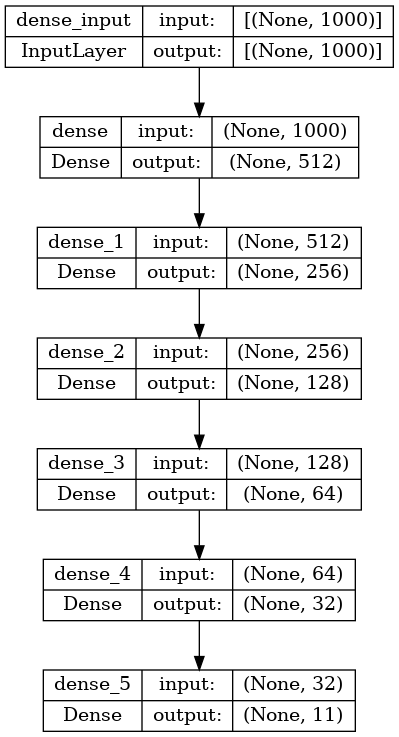

In [5]:
# Plot and save the model structure
model_structure_file = os.path.join(dir_output, 'model_structure.png')
plot_model(model, to_file=model_structure_file, show_shapes=True, show_layer_names=True)
print(f"Model structure saved to: {model_structure_file}")
display(Image(filename=model_structure_file))

# Plot the loss curve of the training process

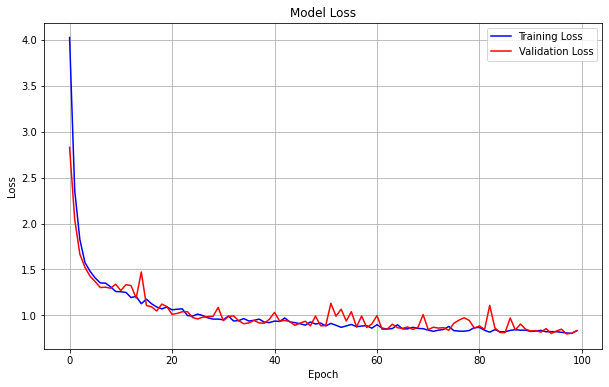

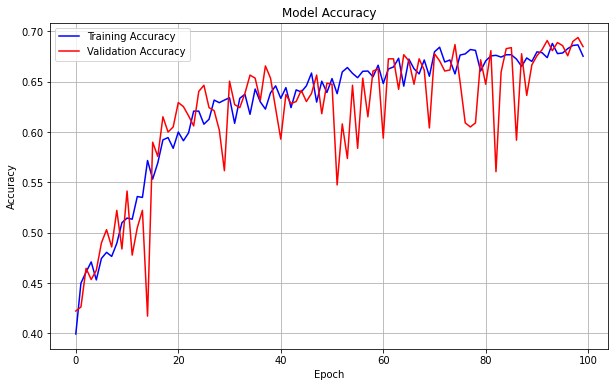

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_loss.png'))
plt.show()
# Draw the accuracy curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_accuracy.png'))
plt.show()


# Predict and calculate accuracy

## Prediction and Comparison:
- The trained model is loaded using `load_model` function to predict the classes for the test set (`X_test`).
- `y_test_classes`: The true class labels for the test set are adjusted based on the minimum label (`min_label`).
- `y_pred_classes`: The predicted class labels for the test set are obtained by selecting the class with the highest probability from the model's output.
  
## Accuracy Calculation:
- The accuracy of the predictions is computed using `accuracy_score` between the true and predicted class labels.

## Evaluation Metrics:
- **Mean Squared Error (MSE)**: Measures the average of the squared differences between true and predicted values.
- **R² Score**: A statistical measure of how well the predicted values approximate the true values. The closer to 1, the better the model.
- These metrics are printed and logged for further analysis.

## Save Predictions:
- The predicted class labels (`y_pred_classes`) are saved in a CSV file (`predictions.csv`) for later analysis.

## Confusion Matrix:
- A confusion matrix is generated using `confusion_matrix` to visually assess the performance of the classification model.
- The matrix is plotted using a heatmap, showing the true versus predicted values.

## Classification Report:
- A detailed classification report (`classification_report`) is generated to evaluate the precision, recall, f1-score, and support for each class.
- This report is saved as `classification_report.txt` for documentation purposes.

## Plot True vs Predicted Values:
- A plot is generated to compare the true values (`y_test_classes`) and predicted values (`y_pred_classes`) over the samples in the test set.
- The plot is saved as `true_vs_predicted.png`.

## Output Files:
- Predictions: `predictions.csv`
- Confusion Matrix: `confusion_matrix.png`
- Classification Report: `classification_report.txt`
- True vs Predicted Plot: `true_vs_predicted.png`


2.0
16/16 [==============================] - 0s 4ms/step


Test MSE: 0.474747
Test R² Score: 0.944307
Test accuracy: 0.668687


Test MSE: 0.474747
Test R² Score: 0.944307
Test accuracy: 0.668687


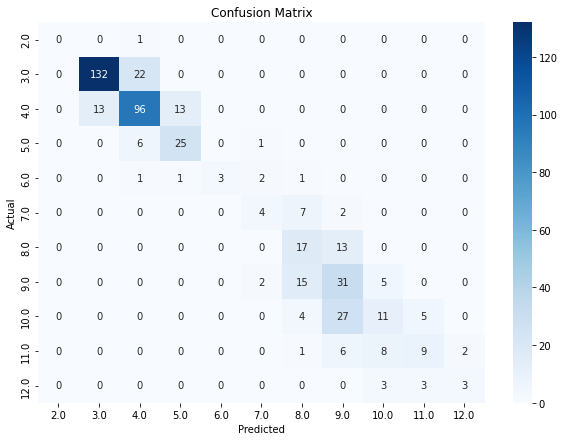

/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.91      0.86      0.88       154
         4.0       0.76      0.79      0.77       122
         5.0       0.64      0.78      0.70        32
         6.0       1.00      0.38      0.55         8
         7.0       0.44      0.31      0.36        13
         8.0       0.38      0.57      0.45        30
         9.0       0.39      0.58      0.47        53
        10.0       0.41      0.23      0.30        47
        11.0       0.53      0.35      0.42        26
        12.0       0.60      0.33      0.43         9

    accuracy                           0.67       495
   macro avg       0.55      0.47      0.49       495
weighted avg       0.68      0.67      0.67       495



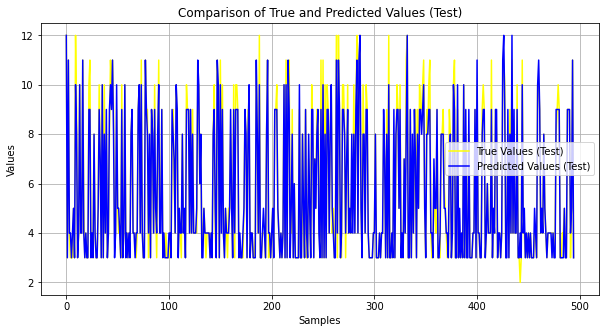

In [7]:
print(min_label)
# Predict and calculate accuracy
model = load_model(model_file)
y_test_classes = np.argmax(y_test, axis=1) + min_label 
y_pred = model.predict(X_test)
y_pred_classes  = np.argmax(y_pred, axis=1) + min_label   
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
# Calculate and print Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test_classes, y_pred_classes)
r2 = r2_score(y_test_classes, y_pred_classes)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")
print(f"Test accuracy: {test_accuracy:.6f}")
logging.info(f"Test accuracy: {test_accuracy:.6f}")
#print(f'Test Accuracy: {accuracy * 100:.2f}%')
# Save predictions
np.savetxt(os.path.join(dir_output, 'predictions.csv'), y_pred_classes, delimiter=',', fmt='%d')

comparison = np.stack((y_test_classes, y_pred_classes), axis=-1)
np.savetxt(os.path.join(dir_output, 'true_vs_predicted_classification.csv'), comparison, delimiter=',', fmt='%d', header='True,Predicted')
#test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
#print(f"Test accuracy: {test_accuracy:.6f}")
cm = confusion_matrix(y_test_classes, y_pred_classes)
labels = np.arange(min_label, min_label + cm.shape[0])
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(dir_output, 'confusion_matrix.png'))
plt.show()
# print the report of prediction
report = classification_report(y_test_classes, y_pred_classes)
print(report)
report_path = os.path.join(dir_output, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
plt.figure(figsize=(10, 5))
plt.plot(y_test_classes, label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred_classes, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted.png'))
plt.show()
